# Define z_score etc.

In [31]:
import torch
def z_score(x, mean, std):
    """
    Z-score normalization function: $z = (X - \mu) / \sigma $,
    where z is the z-score, X is the value of the element,
    $\mu$ is the population mean, and $\sigma$ is the standard deviation.
    :param x: torch array, input array to be normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    :return: torch array, z-score normalized array.
    """
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    """
    Undo the Z-score calculation
    :param x_normed: torch array, input array to be un-normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    """
    return x_normed * std  + mean


def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
    """
    Mean absolute error.
             :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))

def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    """"
    Given distances between all nodes, convert into a weight matrix
    :param W distances
    :param sigma2 User configurable parameter to adjust sparsity of matrix
    :param epsilon User configurable parameter to adjust sparsity of matrix
    :param gat_version If true, use 0/1 weights with self loops. Otherwise, use float
    """
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
        W[W > 0] = 1
        W += np.identity(n)

    return W


# Dataloader <a class="anchor" id="creatDataloader"></a>

In [32]:
import numpy as np
import pandas as pd
import os
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile


class CarbonDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """

    def __init__(self, config, W, root="", transform=None, pre_transform=None):
        self.config = config
        self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(
            self.processed_paths[0]
        )

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, "emissions.csv")]

    @property
    def processed_file_names(self):
        return ["./data.pt"]

    def download(self):
        copyfile(
            "/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/emissions.csv",
            os.path.join(self.raw_dir, "emissions.csv"),
        )

        # url = 'https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/emissions.csv?raw=true'
        # response = requests.get(url)
        # with open(os.path.join(self.raw_dir, 'emissions.csv'), 'wb') as f:
        #     f.write(response.content)

    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        data = pd.read_csv(self.raw_file_names[0], header=None).values
        # Technically using the validation and test datasets here, but it's fine, would normally get the
        # mean and std_dev from a large dataset
        mean = np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))

        _, n_node = data.shape
        n_window = self.config["N_PRED"] + self.config["N_HIST"]

        # manipulate nxn matrix into 2xnum_edges
        edge_index = torch.zeros((2, n_node**2), dtype=torch.long)
        # create an edge_attr matrix with our weights  (num_edges x 1) --> our edge features are dim 1
        edge_attr = torch.zeros((n_node**2, 1))
        num_edges = 0
        for i in range(n_node):
            for j in range(n_node):
                if self.W[i, j] != 0.0:
                    edge_index[0, num_edges] = i
                    edge_index[1, num_edges] = j
                    edge_attr[num_edges] = self.W[i, j]
                    num_edges += 1

        # using resize_ to just keep the first num_edges entries
        edge_index = edge_index.resize_(2, num_edges)
        edge_attr = edge_attr.resize_(num_edges, 1)

        # Add grp edge_index and edge_weight
        grp_edge_index = pd.read_csv(
            "/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/grp_edge_index.csv"
        ).values
        grp_edge_index = torch.tensor(grp_edge_index)
        grp_edge_attr = pd.read_csv(
            "/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/grp_edge_weight.csv"
        ).values
        grp_edge_attr = torch.tensor(grp_edge_attr)
        grp_num_edges = len(grp_edge_attr)

        # Combine the two edge indices and weights
        edge_index = torch.cat([edge_index, grp_edge_index], dim=1)
        edge_attr = torch.cat([edge_attr, grp_edge_attr], dim=0)

        sequences = []

        # T x F x N
        for i in range(self.config["N_SLOT"]):
            # for each time point construct a different graph with data object
            # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
            g = Data()
            g.__num_nodes__ = n_node

            g.edge_index = edge_index
            g.edge_attr = edge_attr

            # (F,N) switched to (N,F)
            sta = i
            end = sta + n_window
            # [21, 228]
            full_window = np.swapaxes(data[sta:end, :], 0, 1)
            g.x = torch.FloatTensor(full_window[:, 0 : self.config["N_HIST"]])
            g.y = torch.FloatTensor(full_window[:, self.config["N_HIST"] : :])
            sequences += [g]

        # Make the actual dataset
        data, slices = self.collate(sequences)

        torch.save((data, slices, n_node, mean, std_dev), self.processed_paths[0])


def get_splits(dataset: CarbonDataset, n_slot, splits):
    """
    Given the data, split it into random subsets of train, val, and test as given by splits
    :param dataset: CarbonDataset object to split
    :param n_slot: Number of possible sliding windows in a day
    :param splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = split_train
    j = split_val
    train = dataset[:i]
    val = dataset[i : i + j]
    test = dataset[i + j :]

    return train, val, test

# ST_GAT Model

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class ST_GAT(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """

    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        self.n_preds = 2
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(
            in_channels=in_channels,
            out_channels=in_channels,
            heads=heads,
            dropout=0,
            concat=False,
        )

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(
            input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1
        )
        for name, param in self.lstm1.named_parameters():
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)
            elif "weight" in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(
            input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1
        )
        for name, param in self.lstm1.named_parameters():
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)
            elif "weight" in name:
                torch.nn.init.xavier_uniform_(param)

        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes * self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x, edge_index_1, edge_attr_1, edge_index_2, edge_attr_2 = (
            data.x,
            data.edge_index[0:140],
            data.edge_attr[0:140],
            data.edge_index[141:465],
            data.edge_attr[141:465],
        )
        # apply dropout
        if device == "cpu":
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        # gat layer: output of gat: [11400, 12]
        x_1 = self.gat(x, edge_index_1, edge_attr=edge_attr_1)
        x_2 = self.gat(x, edge_index_2, edge_attr=edge_attr_2)
        x = torch.cat((x_1, x_2), dim=1)
        x = F.dropout(x, self.dropout, training=self.training)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes / batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)
        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))

        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0] * self.n_nodes, self.n_pred))
        return x

# Train and Evaluation functions <a class="anchor" id="trainEval"></a>

In [45]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()


@torch.no_grad()
def eval(model, device, dataloader, type=""):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        print(batch)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = un_z_score(
                truth, dataloader.dataset.mean, dataloader.dataset.std_dev
            )
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, : pred.shape[0], :] = pred
            y_truth[i, : pred.shape[0], :] = truth

            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1

    rmse, mae, mape = rmse / n, mae / n, mape / n
    print(f"{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")

    # get the average score for each metric in each batch
    return rmse, mae, mape, y_pred, y_truth


def train(model, device, dataloader, optimizer, loss_fn, epoch):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

# Model_train & model_eval

In [46]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

# Make a tensorboard writer
writer = SummaryWriter()

def model_train(train_dataloader, val_dataloader, config, device):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is 228x12: N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT']) 
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss

    model.to(device)

    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        print(f"Loss: {loss:.3f}")
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)

    writer.flush()
    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')


# Config <a class="anchor" id="training"></a>

In [6]:
# %load_ext tensorboard
# %tensorboard --logdir ./runs

In [47]:
from torch_geometric.loader import DataLoader

# Constant config to use throughout
config = {
    'BATCH_SIZE': 8,
    'EPOCHS': 60, # 60 default
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': 2,
    'N_HIST': 4,
    'DROPOUT': 0.2,
    # # number of possible 5 minute measurements per day
    # 'N_DAY_SLOT': 288,
    # # number of days worth of data in the dataset
    # 'N_DAYS': 44,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 31,
}
# Number of possible windows in a day
config['N_SLOT']= 1461 - (config['N_PRED']+config['N_HIST']) + 1

# Load the weight and dataset dataset
distances = pd.read_csv('/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/distance.csv', header=None).values
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
dataset = CarbonDataset(config, W)

# Train

In [48]:
# total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (430, 150, 150))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

# Get gpu if you can
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

# Configure and train model
config['N_NODE'] = dataset.n_node
model = model_train(train_dataloader, val_dataloader, config, device)

Using cpu


Epoch 0: 100%|██████████| 54/54 [00:00<00:00, 78.25it/s]


Loss: 0.465
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 1: 100%|██████████| 54/54 [00:00<00:00, 107.74it/s]


Loss: 0.021


Epoch 2: 100%|██████████| 54/54 [00:00<00:00, 118.39it/s]


Loss: 0.040


Epoch 3: 100%|██████████| 54/54 [00:00<00:00, 116.17it/s]


Loss: 0.026


Epoch 4: 100%|██████████| 54/54 [00:00<00:00, 123.78it/s]


Loss: 0.020


Epoch 5: 100%|██████████| 54/54 [00:00<00:00, 116.79it/s]


Loss: 0.019
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 6: 100%|██████████| 54/54 [00:00<00:00, 114.48it/s]


Loss: 0.016


Epoch 7: 100%|██████████| 54/54 [00:00<00:00, 105.77it/s]


Loss: 0.023


Epoch 8: 100%|██████████| 54/54 [00:00<00:00, 115.80it/s]


Loss: 0.025


Epoch 9: 100%|██████████| 54/54 [00:00<00:00, 126.24it/s]


Loss: 0.019


Epoch 10: 100%|██████████| 54/54 [00:00<00:00, 117.25it/s]


Loss: 0.018
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 11: 100%|██████████| 54/54 [00:00<00:00, 120.44it/s]


Loss: 0.014


Epoch 12: 100%|██████████| 54/54 [00:00<00:00, 120.54it/s]


Loss: 0.013


Epoch 13: 100%|██████████| 54/54 [00:00<00:00, 116.23it/s]


Loss: 0.022


Epoch 14: 100%|██████████| 54/54 [00:00<00:00, 103.98it/s]


Loss: 0.015


Epoch 15: 100%|██████████| 54/54 [00:00<00:00, 114.46it/s]


Loss: 0.013
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 16: 100%|██████████| 54/54 [00:00<00:00, 108.19it/s]


Loss: 0.012


Epoch 17: 100%|██████████| 54/54 [00:00<00:00, 95.86it/s] 


Loss: 0.013


Epoch 18: 100%|██████████| 54/54 [00:00<00:00, 110.71it/s]


Loss: 0.014


Epoch 19: 100%|██████████| 54/54 [00:00<00:00, 111.30it/s]


Loss: 0.019


Epoch 20: 100%|██████████| 54/54 [00:00<00:00, 111.86it/s]


Loss: 0.010
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 21: 100%|██████████| 54/54 [00:00<00:00, 101.88it/s]


Loss: 0.033


Epoch 22: 100%|██████████| 54/54 [00:00<00:00, 117.28it/s]


Loss: 0.010


Epoch 23: 100%|██████████| 54/54 [00:00<00:00, 118.14it/s]


Loss: 0.008


Epoch 24: 100%|██████████| 54/54 [00:00<00:00, 115.71it/s]


Loss: 0.013


Epoch 25: 100%|██████████| 54/54 [00:00<00:00, 117.05it/s]


Loss: 0.028
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 26: 100%|██████████| 54/54 [00:00<00:00, 121.07it/s]


Loss: 0.009


Epoch 27: 100%|██████████| 54/54 [00:00<00:00, 120.85it/s]


Loss: 0.012


Epoch 28: 100%|██████████| 54/54 [00:00<00:00, 113.12it/s]


Loss: 0.018


Epoch 29: 100%|██████████| 54/54 [00:00<00:00, 124.55it/s]


Loss: 0.006


Epoch 30: 100%|██████████| 54/54 [00:00<00:00, 121.91it/s]


Loss: 0.005
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 31: 100%|██████████| 54/54 [00:00<00:00, 115.26it/s]


Loss: 0.008


Epoch 32: 100%|██████████| 54/54 [00:00<00:00, 112.70it/s]


Loss: 0.008


Epoch 33: 100%|██████████| 54/54 [00:00<00:00, 114.29it/s]


Loss: 0.009


Epoch 34: 100%|██████████| 54/54 [00:00<00:00, 107.76it/s]


Loss: 0.006


Epoch 35: 100%|██████████| 54/54 [00:00<00:00, 100.75it/s]


Loss: 0.008
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 36: 100%|██████████| 54/54 [00:00<00:00, 114.16it/s]


Loss: 0.018


Epoch 37: 100%|██████████| 54/54 [00:00<00:00, 119.32it/s]


Loss: 0.008


Epoch 38: 100%|██████████| 54/54 [00:00<00:00, 117.28it/s]


Loss: 0.007


Epoch 39: 100%|██████████| 54/54 [00:00<00:00, 123.12it/s]


Loss: 0.006


Epoch 40: 100%|██████████| 54/54 [00:00<00:00, 119.33it/s]


Loss: 0.010
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 41: 100%|██████████| 54/54 [00:00<00:00, 120.80it/s]


Loss: 0.009


Epoch 42: 100%|██████████| 54/54 [00:00<00:00, 109.40it/s]


Loss: 0.031


Epoch 43: 100%|██████████| 54/54 [00:00<00:00, 117.15it/s]


Loss: 0.009


Epoch 44: 100%|██████████| 54/54 [00:00<00:00, 118.21it/s]


Loss: 0.004


Epoch 45: 100%|██████████| 54/54 [00:00<00:00, 120.65it/s]


Loss: 0.009
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 46: 100%|██████████| 54/54 [00:00<00:00, 113.59it/s]


Loss: 0.006


Epoch 47: 100%|██████████| 54/54 [00:00<00:00, 114.27it/s]


Loss: 0.011


Epoch 48: 100%|██████████| 54/54 [00:00<00:00, 117.56it/s]


Loss: 0.007


Epoch 49: 100%|██████████| 54/54 [00:00<00:00, 109.78it/s]


Loss: 0.010


Epoch 50: 100%|██████████| 54/54 [00:00<00:00, 119.56it/s]


Loss: 0.006
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 51: 100%|██████████| 54/54 [00:00<00:00, 115.62it/s]


Loss: 0.005


Epoch 52: 100%|██████████| 54/54 [00:00<00:00, 118.76it/s]


Loss: 0.007


Epoch 53: 100%|██████████| 54/54 [00:00<00:00, 118.09it/s]


Loss: 0.006


Epoch 54: 100%|██████████| 54/54 [00:00<00:00, 116.84it/s]


Loss: 0.006


Epoch 55: 100%|██████████| 54/54 [00:00<00:00, 107.88it/s]


Loss: 0.006
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9])
DataBatch(edge_index=[2, 1120], edge_attr=[1120, 1], x=[248, 4], y=[248, 2], batch=[248], ptr=[9]

Epoch 56: 100%|██████████| 54/54 [00:00<00:00, 109.38it/s]


Loss: 0.005


Epoch 57: 100%|██████████| 54/54 [00:00<00:00, 117.32it/s]


Loss: 0.007


Epoch 58: 100%|██████████| 54/54 [00:00<00:00, 120.44it/s]


Loss: 0.005


Epoch 59: 100%|██████████| 54/54 [00:00<00:00, 117.08it/s]

Loss: 0.007


# Test the model <a class="anchor" id="test"></a>

In [43]:
import csv

filename = "/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/emissions.csv"

with open(filename, "r") as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)

node_names = header[1:]

Test, MAE: 0.0586252324283123, RMSE: 0.08235381543636322, MAPE: 12.708050727844238


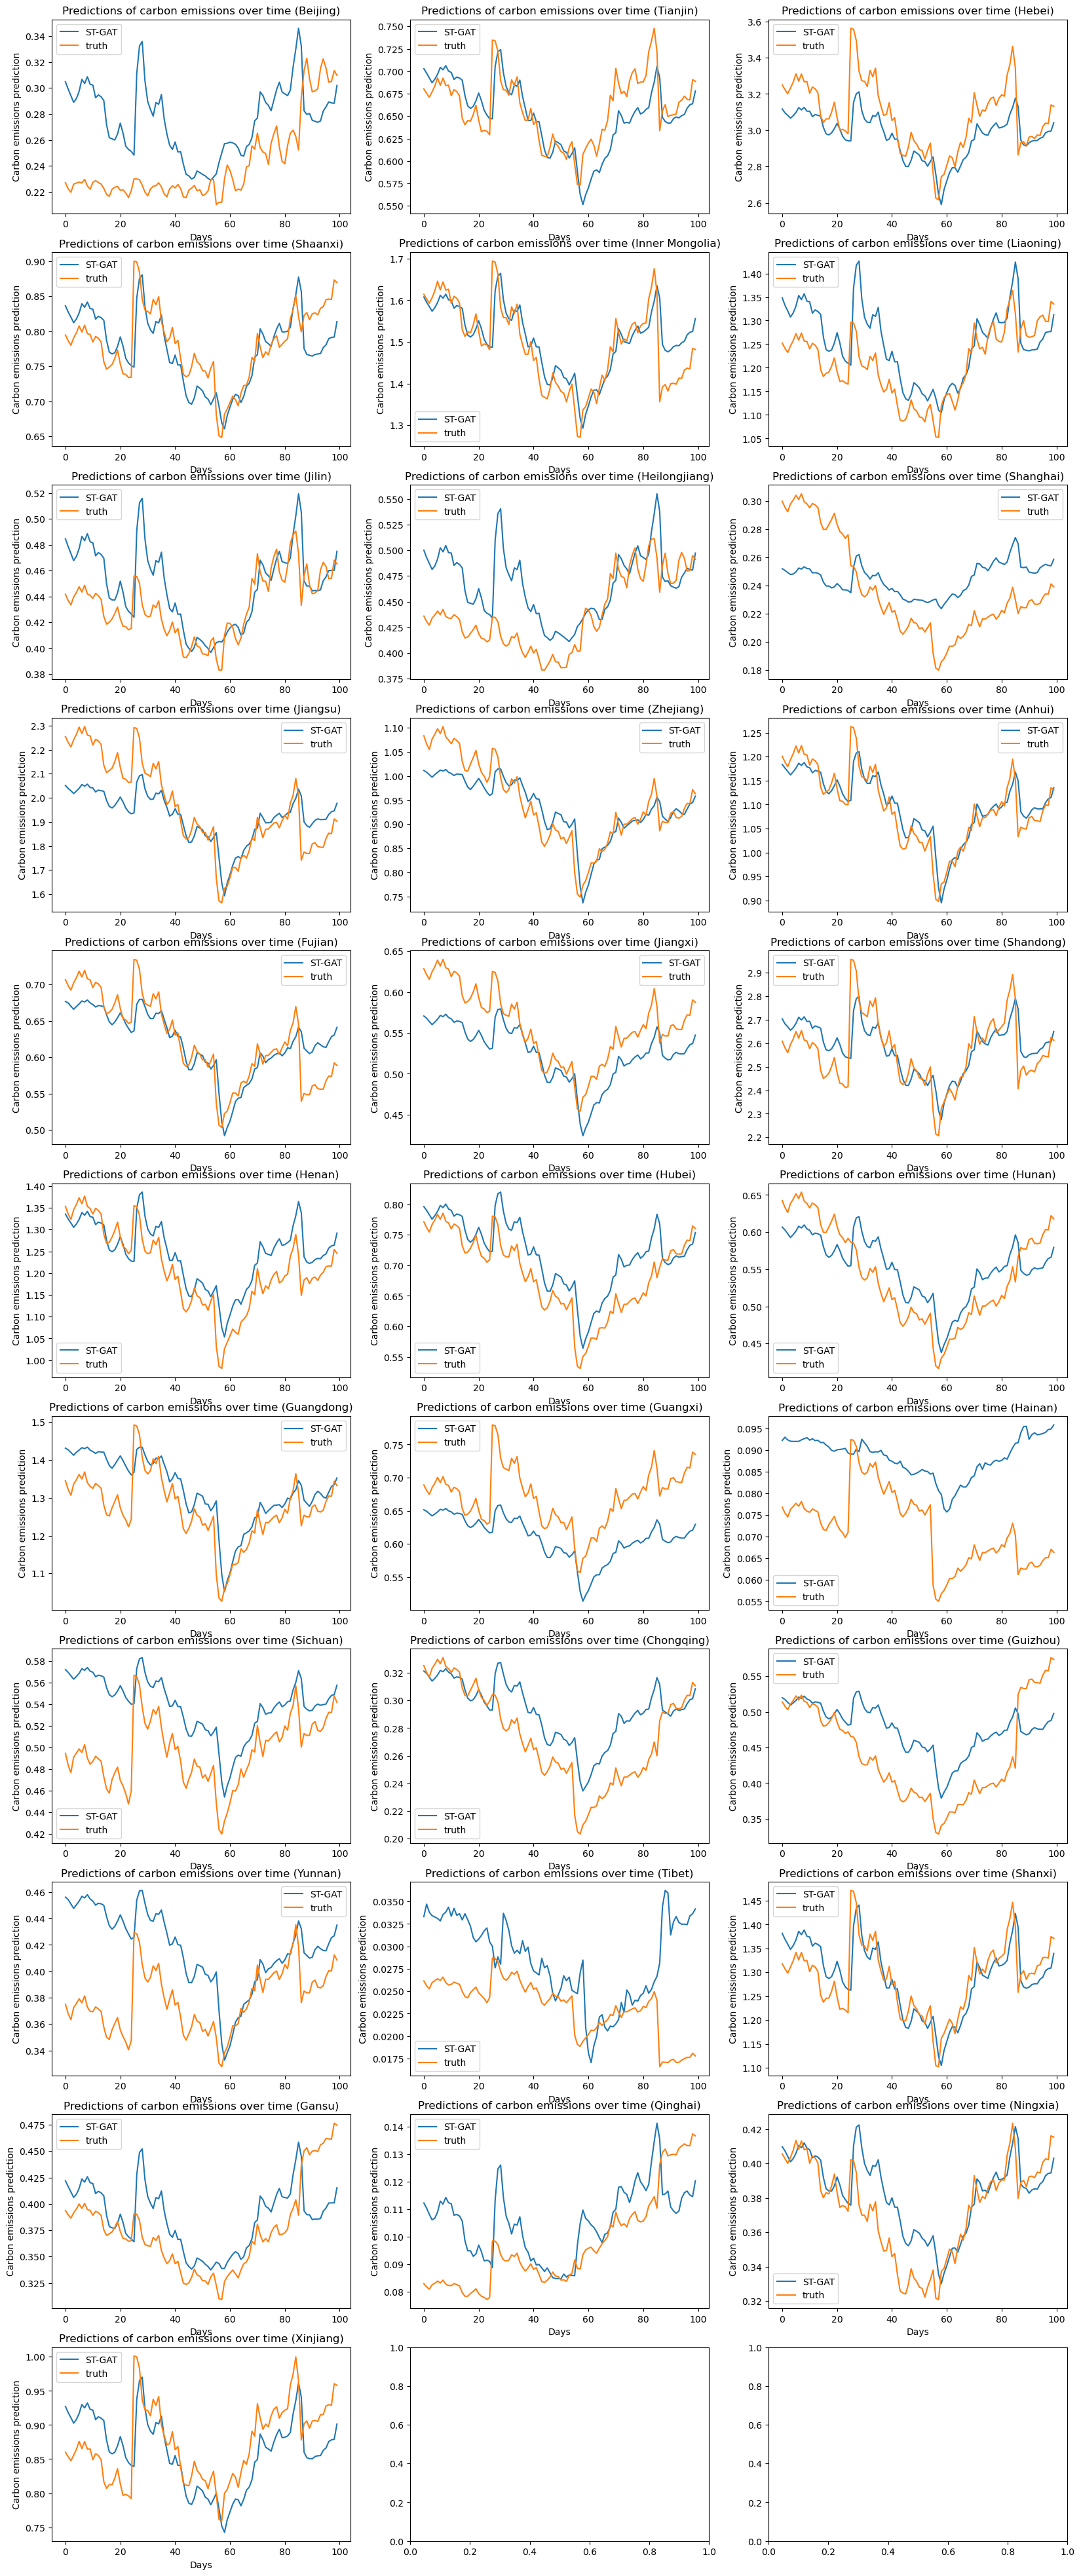

In [44]:
def plot_predictions(test_dataloader, y_pred, y_truth, node_names, config):
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    
    fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(20, 50))
    node = 0
    
    # Loop through each row and column and plot the corresponding node's predictions
    for row in range(11):
        for col in range(3):
            if node >= config['N_NODE']:
                break
            y_truth_node = y_truth[:, :, node, 0].flatten()[:100]
            y_pred_node = y_pred[:, :, node, 0].flatten()[:100]
            t = [t for t in range(0, 100, 1)]
            axes[row, col].plot(t, y_pred_node, label='ST-GAT')
            axes[row, col].plot(t, y_truth_node, label='truth')
            axes[row, col].set_xlabel('Days')
            axes[row, col].set_ylabel('Carbon emissions prediction')
            axes[row, col].set_title(f'Predictions of carbon emissions over time ({node_names[node]})')
            axes[row, col].legend()
            node += 1
    
    plt.savefig('results/predicted_times_grp.png')
    plt.show()
_, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
plot_predictions(test_dataloader, y_pred, y_truth, node_names, config)